<a href="https://colab.research.google.com/github/vimesh630/Revenue_Forecasting/blob/main/XGBoost_for_Revenue_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Import Required Libraies and Mount Google Drive

In [6]:
import numpy as np
import sympy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#2. Define File Paths

In [7]:
output_dir = "/content/drive/MyDrive/VERGER/Revenue_Forecasting"
train_path = os.path.join(output_dir, "train_feature_engineered_forecast_data.csv")
test_path = os.path.join(output_dir, "test_feature_engineered_forecast_data.csv")

#3. Load the Data

In [8]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

#4. Handle Infinite Values and NaNs

In [9]:
train_df = train_df.replace([np.inf, -np.inf], np.nan).fillna(0)
test_df = test_df.replace([np.inf, -np.inf], np.nan).fillna(0)

#5. Prepare Features and Targets

In [10]:
target_col = "Forecast_Revenue"
drop_cols = ["Year", "Month", "Account", "Product", "Type", "Quarter", "date"]

X_train = train_df.drop(columns=drop_cols + [target_col], errors="ignore")
y_train = train_df[target_col]

X_test = test_df.drop(columns=drop_cols + [target_col], errors="ignore")
y_test = test_df[target_col]

#6. Log-Transform the Target

In [19]:
y_train_log = np.log1p(y_train)  # log(1 + y)
y_test_log = np.log1p(y_test)

#7. Train the Model

In [20]:
model = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(
    X_train, y_train_log,
    eval_set=[(X_test, y_test_log)],
    verbose=True
)

[0]	validation_0-rmse:1.49092
[1]	validation_0-rmse:1.44142
[2]	validation_0-rmse:1.37939
[3]	validation_0-rmse:1.31958
[4]	validation_0-rmse:1.26301
[5]	validation_0-rmse:1.22307
[6]	validation_0-rmse:1.16954
[7]	validation_0-rmse:1.12818
[8]	validation_0-rmse:1.09879
[9]	validation_0-rmse:1.05475
[10]	validation_0-rmse:1.01633
[11]	validation_0-rmse:0.97597
[12]	validation_0-rmse:0.95776
[13]	validation_0-rmse:0.91911
[14]	validation_0-rmse:0.88307
[15]	validation_0-rmse:0.85015
[16]	validation_0-rmse:0.82070
[17]	validation_0-rmse:0.78942
[18]	validation_0-rmse:0.76079
[19]	validation_0-rmse:0.73387
[20]	validation_0-rmse:0.70744
[21]	validation_0-rmse:0.67983
[22]	validation_0-rmse:0.65605
[23]	validation_0-rmse:0.63224
[24]	validation_0-rmse:0.61231
[25]	validation_0-rmse:0.59267
[26]	validation_0-rmse:0.57595
[27]	validation_0-rmse:0.55850
[28]	validation_0-rmse:0.55269
[29]	validation_0-rmse:0.53539
[30]	validation_0-rmse:0.52159
[31]	validation_0-rmse:0.50383
[32]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

#8. Predictions

In [21]:
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)  # reverse log1p

#9. Evaluation

In [26]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("\n📊 Model Performance (Log-Transformed Training):")
print(f"RMSE: {rmse:,.2f}")
print(f"MAE: {mae:,.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")


📊 Model Performance (Log-Transformed Training):
RMSE: 6,471.64
MAE: 1,492.44
MAPE: 12.08%
R²: 0.9526


#10. Save Model

In [15]:
model.save_model(os.path.join(output_dir, "xgboost_revenue_model_weighted.json"))
print(f"✅ Weighted model saved to: {os.path.join(output_dir, 'xgboost_revenue_model_weighted.json')}")

✅ Weighted model saved to: /content/drive/MyDrive/VERGER/Revenue_Forecasting/xgboost_revenue_model_weighted.json


# Feature Importance

/tmp/ipython-input-2006740044.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


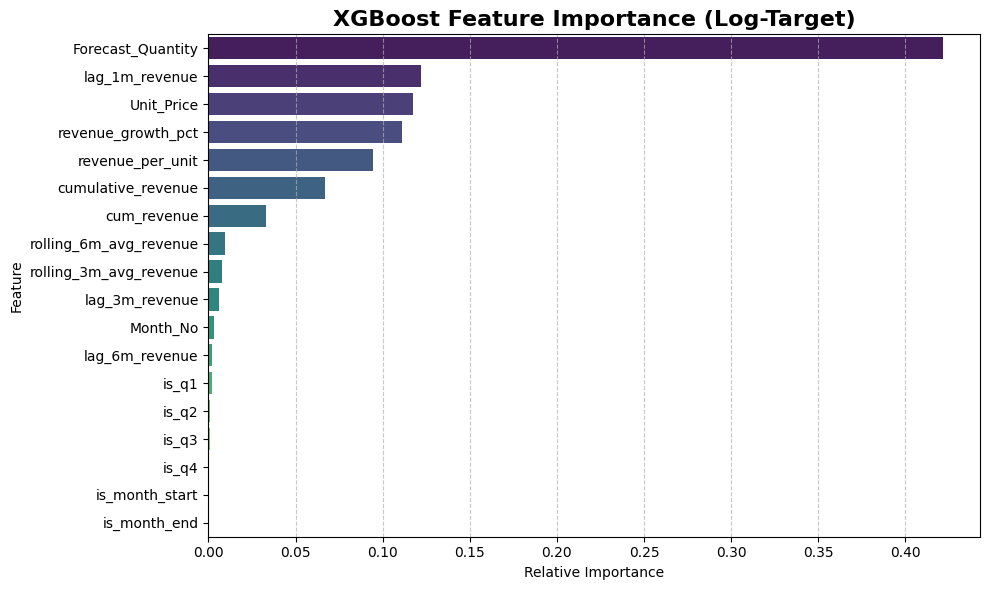

In [27]:
importances = model.feature_importances_
feat_imp_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance',
    y='Feature',
    data=feat_imp_df,
    palette='viridis'
)
plt.title('XGBoost Feature Importance (Log-Target)', fontsize=16, weight='bold')
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#11. Residual Analysis

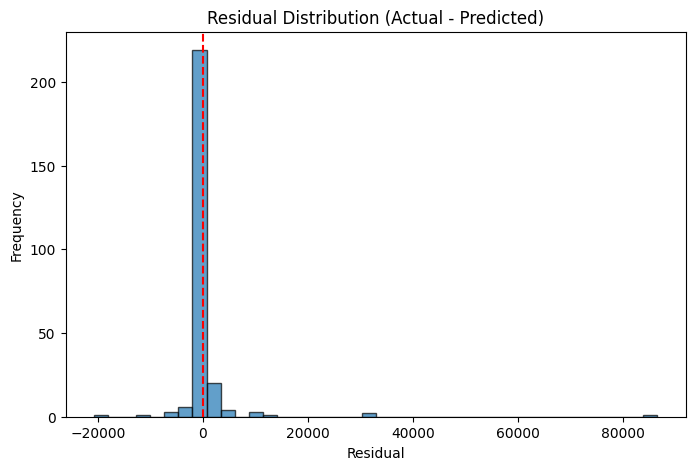

In [23]:
residuals = y_test - y_pred

plt.figure(figsize=(8,5))
plt.hist(residuals, bins=40, edgecolor='black', alpha=0.7)
plt.axvline(0, color='red', linestyle='--')
plt.title("Residual Distribution (Actual - Predicted)")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

#12. Actual Vs Predicted Plot

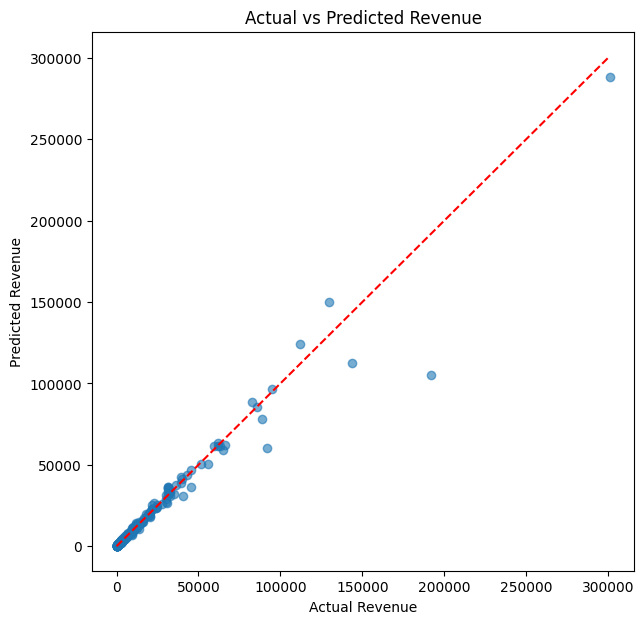

In [24]:
plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Revenue")
plt.ylabel("Predicted Revenue")
plt.title("Actual vs Predicted Revenue")
plt.show()

#13. Segmented Performance

In [25]:
test_results = pd.DataFrame({"Actual": y_test, "Predicted": y_pred})
test_results["Error"] = test_results["Actual"] - test_results["Predicted"]
test_results["APE"] = np.abs(test_results["Error"] / test_results["Actual"]) * 100

segments = {
    "<5K": test_results[test_results["Actual"] < 5000],
    "5K-10K": test_results[(test_results["Actual"] >= 5000) & (test_results["Actual"] < 10000)],
    ">10K": test_results[test_results["Actual"] >= 10000],
}

print("\n📊 Segmented Performance (Weighted):")
for seg, data in segments.items():
    if len(data) > 0:
        seg_mae = data["Error"].abs().mean()
        seg_mape = data["APE"].mean()
        print(f"{seg}: MAE={seg_mae:,.2f}, MAPE={seg_mape:.2f}% (n={len(data)})")
    else:
        print(f"{seg}: No data points")


📊 Segmented Performance (Weighted):
<5K: MAE=188.90, MAPE=18.45% (n=121)
5K-10K: MAE=441.93, MAPE=5.67% (n=48)
>10K: MAE=3,754.96, MAPE=7.04% (n=92)
